In [62]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc, auc, classification_report, confusion_matrix


In [63]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [64]:
df = pd.read_csv('https://raw.githubusercontent.com/dharaneishvc/APT-detection-Deep-Learning-IBM/main/NSL-KDD/KDDTrain%2B.txt', names=col_names, encoding='latin-1')

In [65]:
df.drop(['difficulty_level'],axis=1,inplace=True)

In [66]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [67]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


## Pre processing

### Hierarchy Generation

In [68]:
df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

### Standadization

In [69]:
#selection of numeric attribute columns from the dataset
numcol = df.select_dtypes(include = 'number').columns

from sklearn.preprocessing import StandardScaler

#normalizing using standard scalar
std_scalar = StandardScaler()
for i in numcol:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scalar.fit_transform(arr.reshape(len(arr),1))

In [70]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,normal
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,Dos
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,normal
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal


### One Hot Encoding

In [71]:
categ_col = ['protocol_type','service','flag']
ctg = df[categ_col]

#one-hot encoding of categorical attributes
ctg = pd.get_dummies(ctg, columns = categ_col)

In [72]:
ctg

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
125969,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
125970,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
125971,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Binary Classification

This is used for all of the 4 Artificial Neural Network Algorithms since we aim to do Binary Classification of the label either as attack or normal connection.

In [73]:
#categorize attack labels into 'normal' and 'attack'
biny_lbl = pd.DataFrame(df.label.map(lambda x:'normal' if x=='normal' else 'attack'))

In [74]:
#create dataframe with binary label
bin_dataset = df.copy()
bin_dataset['label'] = biny_lbl

In [75]:
#perform label encoding with binary labels
from sklearn import preprocessing

label_one = preprocessing.LabelEncoder()
encode_label = biny_lbl.apply(label_one.fit_transform)
bin_dataset['intrusion'] = encode_label

In [76]:
#one-hot encoding of the attack label
bin_dataset = pd.get_dummies(bin_dataset, columns = ['label'], prefix = "", prefix_sep = "")
bin_dataset['label'] = biny_lbl
bin_dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,attack,normal,label
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,1,0,1,normal
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,1,0,1,normal
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0,1,0,attack
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,1,0,1,normal
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0,1,0,attack
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,1,0,1,normal
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,1,0,1,normal
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0,1,0,attack


### Multi-class Classification

This can be used to classify the connection as what type of attact it is. We don't use this in next 4 deep learning algorithms

In [77]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = df.copy()
multi_label = pd.DataFrame(multi_data.label)


In [78]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
labencd = preprocessing.LabelEncoder()
enc_label = multi_label.apply(labencd.fit_transform)
multi_data['intrusion'] = enc_label


In [79]:
labencd.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [80]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,Dos,Probe,R2L,U2R,normal,label
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.624871,-0.224532,-0.376387,4,0,0,0,0,1,normal
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.624871,-0.387635,-0.376387,4,0,0,0,0,1,normal
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,1.618955,-0.387635,-0.376387,0,1,0,0,0,0,Dos
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.602433,-0.387635,-0.345084,4,0,0,0,0,1,normal
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.624871,-0.387635,-0.376387,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,1.618955,-0.387635,-0.376387,0,1,0,0,0,0,Dos
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.624871,-0.387635,-0.376387,4,0,0,0,0,1,normal
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.624871,-0.355014,-0.376387,4,0,0,0,0,1,normal
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,1.618955,-0.387635,-0.376387,0,1,0,0,0,0,Dos


### Feature Extraction

In [81]:
#creation of dataframe constrained to numeric attributes of encoded label attributes and binary class dataset 
numeric_bin = bin_dataset[numcol]
numeric_bin['intrusion'] = bin_dataset['intrusion']

<ipython-input-81-3f64add70e81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_bin['intrusion'] = bin_dataset['intrusion']


In [82]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)


count                       0.576444
srv_serror_rate             0.648289
serror_rate                 0.650652
dst_host_serror_rate        0.651842
dst_host_srv_serror_rate    0.654985
logged_in                   0.690171
dst_host_same_srv_rate      0.693803
dst_host_srv_count          0.722535
same_srv_rate               0.751913
intrusion                   1.000000
Name: intrusion, dtype: float64

In [83]:
# selecting attributes found by using pearson correlation coefficient
numeric_bin = bin_dataset[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate','logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]
     

In [84]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_bin = numeric_bin.join(ctg)
# then joining encoded, one-hot-encoded, and original attack label attribute
bin_dataset = numeric_bin.join(bin_dataset[['intrusion','attack','normal','label']])

In [85]:
bin_dataset

,count,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,attack,normal,label
0,-0.717045,-0.631929,-0.637209,-0.639532,-0.624871,-0.809262,-0.782367,-0.818890,0.771283,0,...,0,0,0,0,1,0,1,0,1,normal
1,-0.620982,-0.631929,-0.637209,-0.639532,-0.624871,-0.809262,-1.161030,-1.035688,-1.321428,0,...,0,0,0,0,1,0,1,0,1,normal
2,0.339648,1.605104,1.602664,1.608759,1.618955,-0.809262,-0.938287,-0.809857,-1.389669,0,...,1,0,0,0,0,0,0,1,0,attack
3,-0.690846,-0.184522,-0.189235,-0.572083,-0.602433,1.235694,1.066401,1.258754,0.771283,0,...,0,0,0,0,1,0,1,0,1,normal
4,-0.472521,-0.631929,-0.637209,-0.639532,-0.624871,1.235694,1.066401,1.258754,0.771283,0,...,0,0,0,0,1,0,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.872361,1.605104,1.602664,1.608759,1.618955,-0.809262,-0.938287,-0.818890,-1.184947,0,...,1,0,0,0,0,0,0,1,0,attack
125969,-0.717045,-0.631929,-0.637209,-0.639532,-0.624871,-0.809262,0.977304,1.159389,0.771283,0,...,0,0,0,0,1,0,1,0,1,normal
125970,-0.725778,-0.631929,-0.637209,0.979238,-0.624871,1.235694,-0.893738,-0.773724,0.771283,0,...,0,0,0,0,1,0,1,0,1,normal
125971,0.523041,1.605104,1.602664,1.608759,1.618955,-0.809262,-1.094207,-0.972455,-1.366922,0,...,1,0,0,0,0,0,0,1,0,attack


In [86]:

# creating a dataframe with only numeric attributes of multi-class dataset and encoded label attribute 
numeric_multi = multi_data[numcol]
numeric_multi['intrusion'] = multi_data['intrusion']

<ipython-input-86-01adb2b9cdf0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_multi['intrusion'] = multi_data['intrusion']


In [87]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.613251
logged_in                   0.693770
srv_serror_rate             0.710852
serror_rate                 0.712861
dst_host_serror_rate        0.714247
dst_host_same_srv_rate      0.716820
dst_host_srv_serror_rate    0.717387
dst_host_srv_count          0.718579
same_srv_rate               0.798358
intrusion                   1.000000
Name: intrusion, dtype: float64

In [88]:
# selecting attributes found by using pearson correlation coefficient
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]


In [89]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_multi = numeric_multi.join(ctg)
# then joining encoded, one-hot-encoded, and original attack label attribute
multi_data = numeric_multi.join(multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']])


In [90]:
multi_data

,count,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S3,flag_SF,flag_SH,intrusion,Dos,Probe,R2L,U2R,normal,label
0,-0.717045,-0.809262,-0.631929,-0.637209,-0.639532,-0.782367,-0.624871,-0.818890,0.771283,0,...,0,1,0,4,0,0,0,0,1,normal
1,-0.620982,-0.809262,-0.631929,-0.637209,-0.639532,-1.161030,-0.624871,-1.035688,-1.321428,0,...,0,1,0,4,0,0,0,0,1,normal
2,0.339648,-0.809262,1.605104,1.602664,1.608759,-0.938287,1.618955,-0.809857,-1.389669,0,...,0,0,0,0,1,0,0,0,0,Dos
3,-0.690846,1.235694,-0.184522,-0.189235,-0.572083,1.066401,-0.602433,1.258754,0.771283,0,...,0,1,0,4,0,0,0,0,1,normal
4,-0.472521,1.235694,-0.631929,-0.637209,-0.639532,1.066401,-0.624871,1.258754,0.771283,0,...,0,1,0,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.872361,-0.809262,1.605104,1.602664,1.608759,-0.938287,1.618955,-0.818890,-1.184947,0,...,0,0,0,0,1,0,0,0,0,Dos
125969,-0.717045,-0.809262,-0.631929,-0.637209,-0.639532,0.977304,-0.624871,1.159389,0.771283,0,...,0,1,0,4,0,0,0,0,1,normal
125970,-0.725778,1.235694,-0.631929,-0.637209,0.979238,-0.893738,-0.624871,-0.773724,0.771283,0,...,0,1,0,4,0,0,0,0,1,normal
125971,0.523041,-0.809262,1.605104,1.602664,1.608759,-1.094207,1.618955,-0.972455,-1.366922,0,...,0,0,0,0,1,0,0,0,0,Dos


# Deep Learning

bin_dataset is sufficient for Deep Learning. first n-4 are x and intrusion is Y

In [91]:
df2 = bin_dataset.copy()
#df2.to_csv("bin_data.csv")

In [92]:
##create input and output vectors
X = df2.iloc[:,0:df2.shape[1]-4]
Y = df2[['intrusion']]
print(X.shape)
X = X.values.reshape(df2.shape[0], df2.shape[1]-4, 1)
Y = Y.values.reshape(df2.shape[0], 1)

(125973, 93)


In [93]:
Z = Y
from keras.utils import to_categorical
Y = to_categorical(Y)
total_rows = 25192 * 4
max_len=4

In [94]:
## splitting of training and testing data
X_train,X_test,Z_train,Z_test = train_test_split(X,Z,test_size=0.20)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [95]:
print(X_train.shape, Y_train.shape)
print(Y_test.shape, Y_test.shape)

(100778, 1, 93) (100778, 2)
(25195, 2) (25195, 2)


In [103]:
sess1 = tf.compat.v1.Session()

## CNN

In [104]:
#CNN
model2 = Sequential()
model2.add(Conv1D(filters=256, kernel_size = 1, activation='tanh', dtype='float32', input_shape=(1,X.shape[1])))#256
model2.add(Conv1D(filters=128, kernel_size = 1, activation='tanh'))#128
model2.add(Conv1D(filters=64, kernel_size = 1, activation='tanh'))#64
model2.add(Conv1D(filters=32, kernel_size = 1, activation='tanh'))#32
model2.add(MaxPooling1D(pool_size=1))
model2.add(Flatten())
'''
model2.add(Conv1D(128, dropout=0.3, return_sequences=True)) #128
model2.add(Conv1D(64, dropout=0.3, return_sequences=True)) #64
model2.add(Conv1D(32))#32
'''
model2.add(Dense(100, activation='relu'))
model2.add((Dense(2, activation='softmax')))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted2= model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=2458,callbacks=callbacks_list)


Epoch 1/100
40/41 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9331
Epoch 1: val_accuracy improved from -inf to 0.96944, saving model to weights.best.hdf5
41/41 [==============================] - 3s 67ms/step - loss: 0.2363 - accuracy: 0.9339 - val_loss: 0.1157 - val_accuracy: 0.9694
Epoch 2/100
40/41 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9707
Epoch 2: val_accuracy improved from 0.96944 to 0.97194, saving model to weights.best.hdf5
41/41 [==============================] - 2s 49ms/step - loss: 0.0980 - accuracy: 0.9709 - val_loss: 0.0837 - val_accuracy: 0.9719
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9717
Epoch 3: val_accuracy improved from 0.97194 to 0.97365, saving model to weights.best.hdf5
41/41 [==============================] - 2s 51ms/step - loss: 0.0764 - accuracy: 0.9717 - val_loss: 0.0746 - val_accuracy: 0.9736
Epoch 4/100
41/41 [==============================] - ETA: 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 256)            24064     
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 128)            32896     
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 64)             8256      
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 32)             2080      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                      

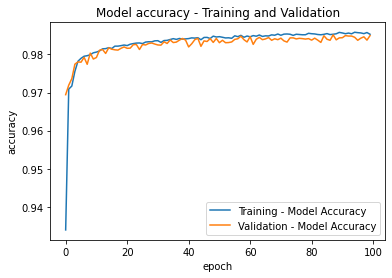

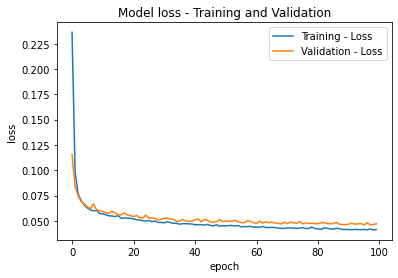

Classification report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11797
           1       0.98      0.99      0.99     13398

    accuracy                           0.98     25195
   macro avg       0.99      0.98      0.98     25195
weighted avg       0.98      0.98      0.98     25195

Confusion Matrix
[[11570   227]
 [  152 13246]]
Accuracy Score        =     0.9849573328041278
Precision Score       =     0.9831514881615082
Recall/Sensitivity    =     0.9886550231377818
Specificity           =     0.980757819784691
F1 Score              =     0.985895575155372


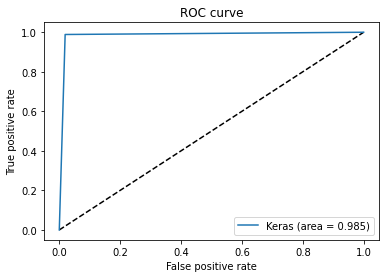

In [105]:
model2.summary()

y_pred = (model2.predict(X_test) > 0.5).astype("int32")
#y_pred = model2.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted2.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted2.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted2.history['loss'], label="Training - Loss")
plt.plot(predicted2.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


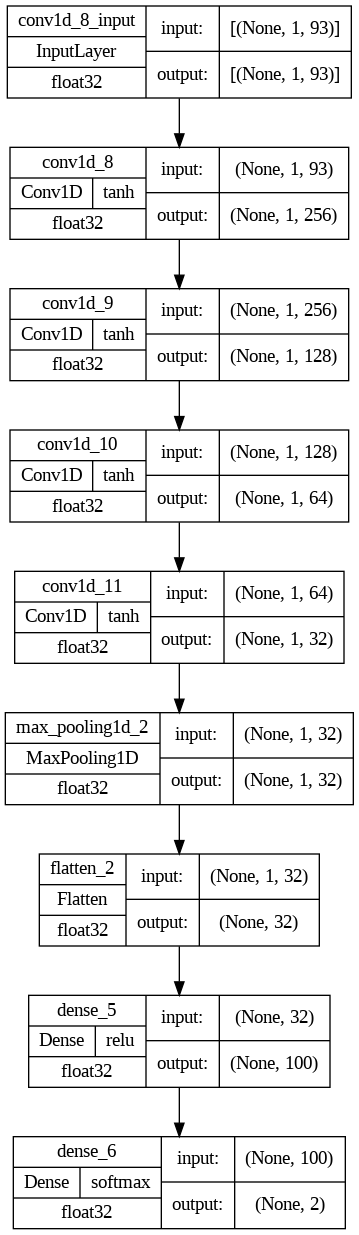

In [106]:
tf.keras.utils.plot_model(model2, to_file='CNN.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

## RNN

In [107]:

#create model (RNN)
model3 = Sequential()
model3.add(SimpleRNN(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True)) #128
model3.add(SimpleRNN(64, dropout=0.3, return_sequences=True)) #64
model3.add(SimpleRNN(32))#32

'''
#(For Single Layer)
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model3.add(SimpleRNN(128))
'''

model3.add((Dense(2, activation='softmax')))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted3= model3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=2458,callbacks=callbacks_list)

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9074
Epoch 1: val_accuracy improved from -inf to 0.96388, saving model to weights.best.hdf5
41/41 [==============================] - 7s 97ms/step - loss: 0.2411 - accuracy: 0.9074 - val_loss: 0.1244 - val_accuracy: 0.9639
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9480
Epoch 2: val_accuracy improved from 0.96388 to 0.96980, saving model to weights.best.hdf5
41/41 [==============================] - 3s 82ms/step - loss: 0.1572 - accuracy: 0.9480 - val_loss: 0.1068 - val_accuracy: 0.9698
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9512
Epoch 3: val_accuracy improved from 0.96980 to 0.97083, saving model to weights.best.hdf5
41/41 [==============================] - 3s 84ms/step - loss: 0.1453 - accuracy: 0.9512 - val_loss: 0.0992 - val_accuracy: 0.9708
Epoch 4/100
41/41 [==============================] - ETA: 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 1, 256)            89600     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 1, 128)            49280     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 1, 64)             12352     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 154,402
Trainable params: 154,402
Non-trainable params: 0
_________________________________________________________________
788/788 [==============================] - 3s 3m

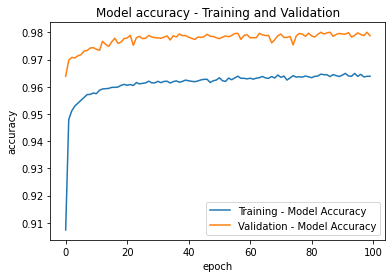

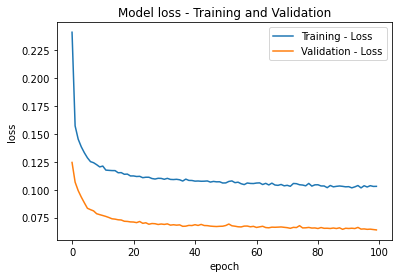

Classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11797
           1       0.97      0.99      0.98     13398

    accuracy                           0.98     25195
   macro avg       0.98      0.98      0.98     25195
weighted avg       0.98      0.98      0.98     25195

Confusion Matrix
[[11411   386]
 [  149 13249]]
Accuracy Score        =     0.9787656281008137
Precision Score       =     0.9716905023835717
Recall/Sensitivity    =     0.9888789371547992
Specificity           =     0.9672798169026023
F1 Score              =     0.980209373728406


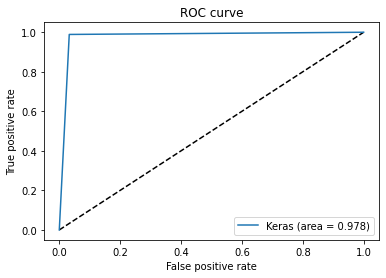

In [108]:
model3.summary()

y_pred = (model3.predict(X_test) > 0.5).astype("int32")
#y_pred = model3.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted3.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted3.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted3.history['loss'], label="Training - Loss")
plt.plot(predicted3.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


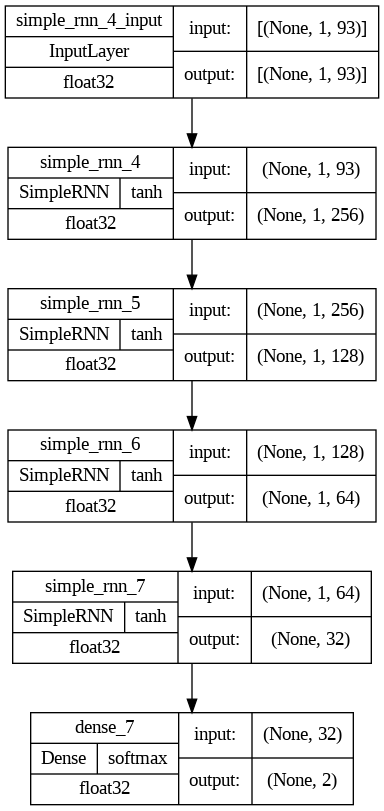

In [109]:
tf.keras.utils.plot_model(model3, to_file='RNN.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

## LSTM

In [110]:
# create the model (LSTM)
# For stacked Layer
embedding_vecor_length = 1
model = Sequential()
model.add(LSTM(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1]))) #256
model.add(LSTM(128, dropout=0.3, return_sequences=True)) #128
model.add(LSTM(64, dropout=0.3, return_sequences=True)) #64
model.add(LSTM(32)) #32

'''
(For Single Layer)
model.add(LSTM(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model.add(LSTM(128))
'''

model.add((Dense(2, activation='softmax')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=2458,callbacks=callbacks_list)

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7698
Epoch 1: val_accuracy improved from -inf to 0.90522, saving model to weights.best.hdf5
41/41 [==============================] - 18s 296ms/step - loss: 0.5964 - accuracy: 0.7698 - val_loss: 0.3803 - val_accuracy: 0.9052
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9276
Epoch 2: val_accuracy improved from 0.90522 to 0.96491, saving model to weights.best.hdf5
41/41 [==============================] - 11s 258ms/step - loss: 0.2502 - accuracy: 0.9276 - val_loss: 0.1367 - val_accuracy: 0.9649
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9509
Epoch 3: val_accuracy improved from 0.96491 to 0.96936, saving model to weights.best.hdf5
41/41 [==============================] - 11s 260ms/step - loss: 0.1543 - accuracy: 0.9509 - val_loss: 0.1132 - val_accuracy: 0.9694
Epoch 4/100
41/41 [==============================] -

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            358400    
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 617,410
Trainable params: 617,410
Non-trainable params: 0
_________________________________________________________________
788/788 [==============================] - 6s 6m

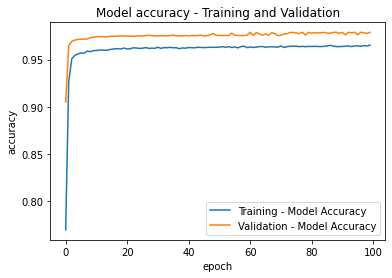

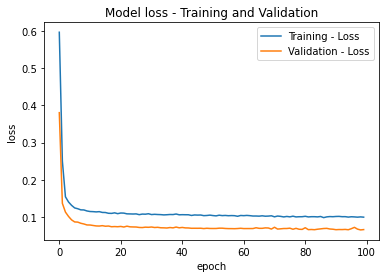

Classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11797
           1       0.97      0.99      0.98     13398

    accuracy                           0.98     25195
   macro avg       0.98      0.98      0.98     25195
weighted avg       0.98      0.98      0.98     25195

Confusion Matrix
[[11398   399]
 [  133 13265]]
Accuracy Score        =     0.9788846993451081
Precision Score       =     0.9707991803278688
Recall/Sensitivity    =     0.990073145245559
Specificity           =     0.9661778418241926
F1 Score              =     0.9803414381789963


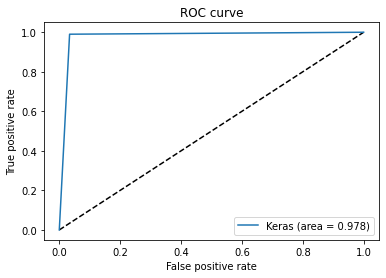

In [111]:
model.summary()

y_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted.history['loss'], label="Training - Loss")
plt.plot(predicted.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


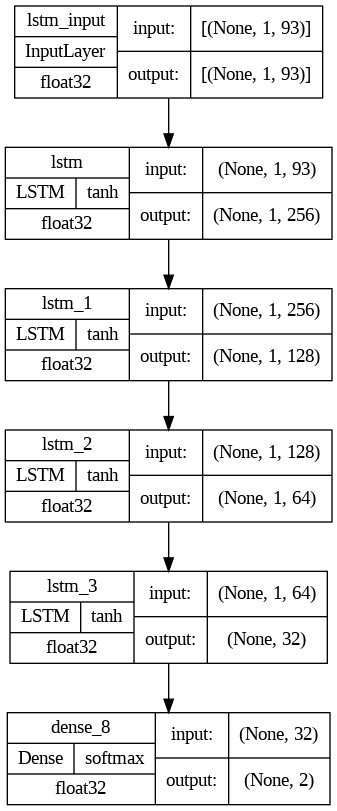

In [112]:
tf.keras.utils.plot_model(model, to_file='LSTM.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

## GRU

In [113]:
#create model (GRU)
# For stacked Layer
model1 = Sequential()
model1.add(GRU(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model1.add(GRU(128, dropout=0.3, return_sequences=True)) #128
model1.add(GRU(64, dropout=0.3, return_sequences=True)) #64
model1.add(GRU(32))#32

'''
(For Single Layer)
model1.add(GRU(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model1.add(GRU(128))
'''

model1.add((Dense(2, activation='softmax')))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted1 = model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=2458,callbacks=callbacks_list)

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8867
Epoch 1: val_accuracy improved from -inf to 0.95761, saving model to weights.best.hdf5
41/41 [==============================] - 16s 246ms/step - loss: 0.3824 - accuracy: 0.8867 - val_loss: 0.1494 - val_accuracy: 0.9576
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9462
Epoch 2: val_accuracy improved from 0.95761 to 0.96908, saving model to weights.best.hdf5
41/41 [==============================] - 9s 210ms/step - loss: 0.1628 - accuracy: 0.9462 - val_loss: 0.1137 - val_accuracy: 0.9691
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9533
Epoch 3: val_accuracy improved from 0.96908 to 0.96999, saving model to weights.best.hdf5
41/41 [==============================] - 9s 210ms/step - loss: 0.1423 - accuracy: 0.9533 - val_loss: 0.1010 - val_accuracy: 0.9700
Epoch 4/100
41/41 [==============================] - E

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 256)            269568    
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            148224    
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             37248     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 464,514
Trainable params: 464,514
Non-trainable params: 0
_________________________________________________________________
788/788 [==============================] - 5s 5m

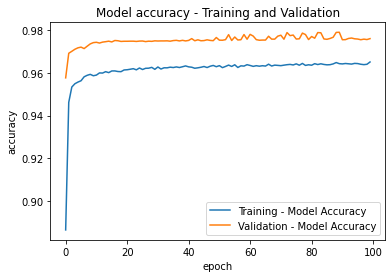

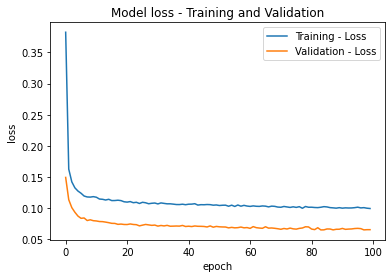

Classification report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     11797
           1       0.96      0.99      0.98     13398

    accuracy                           0.98     25195
   macro avg       0.98      0.97      0.98     25195
weighted avg       0.98      0.98      0.98     25195

Confusion Matrix
[[11302   495]
 [  112 13286]]
Accuracy Score        =     0.9759079182377456
Precision Score       =     0.9640809810608809
Recall/Sensitivity    =     0.9916405433646813
Specificity           =     0.9580401797067051
F1 Score              =     0.9776665808160713


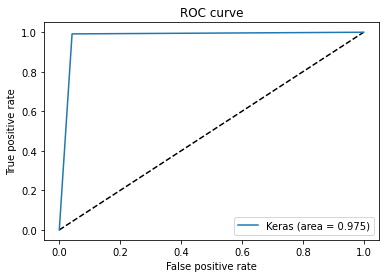

In [114]:
model1.summary()

y_pred = (model1.predict(X_test) > 0.5).astype("int32")
#y_pred = model1.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted1.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted1.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted1.history['loss'], label="Training - Loss")
plt.plot(predicted1.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


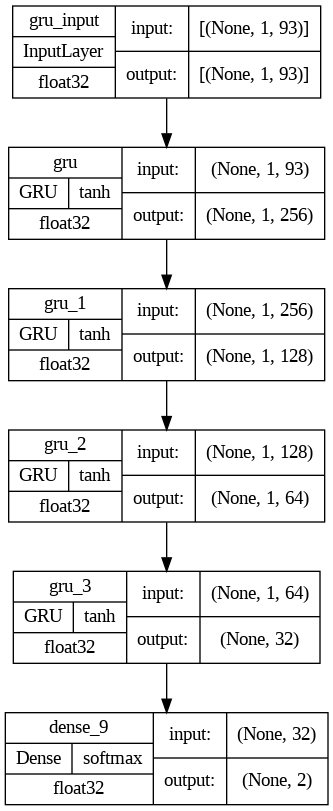

In [115]:
tf.keras.utils.plot_model(model1, to_file='GRU.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )